# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** k-Fold CV in-depth analysis

</font>
</div>

# Methods to estimate your ML algorithm accuracy
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

-  **k-Fold CV** is the gold standard for evaluating the performance of a machine learning algorithm on unseen data with k set to 3, 5, or 10.
- **Train/test split** is good for speed when using a slow algorithm and produces performance estimates with lower bias when using large datasets.
- Techniques like **leave-one-out** and **repeated random splits** can be useful intermediates when trying to balance variance in the estimated performance, model training speed and dataset size.
- **The bottom line?** If in doubt, use 10-Fold CV.
  
</font>
</div>

# Import modules
<hr style="border:2px solid black"> </hr>

In [30]:
from sklearn.datasets import make_classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from numpy import isnan
from numpy import asarray
from numpy import polyfit
from scipy.stats import pearsonr
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Create synthetic dataset
<hr style="border:2px solid black"> </hr>

In [2]:
# define dataset
X, y = make_classification(
    n_samples=100, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# summarize the dataset
print(X.shape, y.shape)

(100, 20) (100,)


<div class="alert alert-info">
<font color=black>

-  We will evaluate a LogisticRegression model and use the KFold class to perform the cross-validation, configured to shuffle the dataset and set k=10, a popular default.
- The cross_val_score() function will be used to perform the evaluation, taking the dataset and cross-validation configuration and returning a list of scores calculated for each fold.

</font>
</div>

In [4]:
# create dataset
X, y = make_classification(
    n_samples=100, n_features=20, n_informative=15, n_redundant=5, random_state=1)

# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# create model
model = LogisticRegression()

# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.850 (0.128)


# Sensitivity Analysis for k
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- **This sections explains how we can tune the k-value and how LOOCV can be used to validate our choice of k.**
- **What is generally done?** Common values are k=3, k=5, and k=10, and by far the most popular value used in applied machine learning to evaluate models is k=10. The reason for this is studies were performed and k=10 was found to provide good trade-off of low computational cost and low bias in an estimate of model performance. 

- **Does k=10 mae sense for your dataset?**
    - *Approach No1*: Perform a sensitivity analysis for different k values. The expectation is that low values of k will result in a noisy estimate of model performance and large values of k will result in a less noisy estimate of model performance. But noisy compared to what? We don’t know the true performance of the model when making predictions on new/unseen data, as we don’t have access to new/unseen data. If we did, we would make use of it in the evaluation of the model. Nevertheless, we can choose a test condition that represents an “ideal” or as-best-as-we-can-achieve “ideal” estimate of model performance. One approach would be to train the model on all available data and estimate the performance on a separate large and representative hold-out dataset. The performance on this hold-out dataset would represent the “true” performance of the model and any cross-validation performances on the training dataset would represent an estimate of this score. This is rarely possible as we often do not have enough data to hold some back and use it as a test set.
    - *Approach No2*: Instead, we can simulate this case using the leave-one-out cross-validation (LOOCV), a computationally expensive version of cross-validation where k=N, and N is the total number of examples in the training dataset. That is, each sample in the training set is given an example to be used alone as the test evaluation dataset. It is rarely used for large datasets as it is computationally expensive, although it can provide a good estimate of model performance given the available data. We can then compare the mean classification accuracy for different k values to the mean classification accuracy from LOOCV on the same dataset. 
    
- **Bottom line?** The difference between LOOCV and different value of ks, provides a rough proxy for how well a k value approximates the ideal model evaluation test condition.

</font>
</div>

In [5]:
# create the dataset
def get_dataset(n_samples=100):
    X, y = make_classification(
        n_samples=n_samples, n_features=20, n_informative=15, n_redundant=5, random_state=1)
    return X, y

In [8]:
# retrieve the model to be evaluate
def get_model():
    model = LogisticRegression()
    return model

In [9]:
# evaluate the model using a given test condition
def evaluate_model(cv):
    # get the dataset
    X, y = get_dataset()
    # get the model
    model = get_model()
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return mean(scores), scores.min(), scores.max()

In [12]:
# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,31)

Ideal: 0.840


In [21]:
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
    # define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    # evaluate k value
    k_mean, k_min, k_max = evaluate_model(cv)
    # report performance
    print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
    # store mean accuracy
    means.append(k_mean)
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)

> folds=2, accuracy=0.740 (0.700,0.780)
> folds=3, accuracy=0.749 (0.697,0.824)
> folds=4, accuracy=0.790 (0.640,0.920)
> folds=5, accuracy=0.810 (0.600,0.950)
> folds=6, accuracy=0.820 (0.688,0.941)
> folds=7, accuracy=0.799 (0.571,1.000)
> folds=8, accuracy=0.811 (0.385,0.923)
> folds=9, accuracy=0.829 (0.636,1.000)
> folds=10, accuracy=0.850 (0.600,1.000)
> folds=11, accuracy=0.829 (0.667,1.000)
> folds=12, accuracy=0.785 (0.250,1.000)
> folds=13, accuracy=0.839 (0.571,1.000)
> folds=14, accuracy=0.807 (0.429,1.000)
> folds=15, accuracy=0.821 (0.571,1.000)
> folds=16, accuracy=0.827 (0.500,1.000)
> folds=17, accuracy=0.816 (0.600,1.000)
> folds=18, accuracy=0.831 (0.600,1.000)
> folds=19, accuracy=0.826 (0.600,1.000)
> folds=20, accuracy=0.830 (0.600,1.000)
> folds=21, accuracy=0.814 (0.500,1.000)
> folds=22, accuracy=0.820 (0.500,1.000)
> folds=23, accuracy=0.802 (0.250,1.000)
> folds=24, accuracy=0.804 (0.250,1.000)
> folds=25, accuracy=0.810 (0.250,1.000)
> folds=26, accuracy=0.8

In [22]:
print(len(folds), len(means))

29 29


<div class="alert alert-info">
<font color=black>

- The results suggest that for this model on this dataset, most k values underestimate the performance of the model compared to the ideal case. 
- The results suggest that perhaps k=10 alone is slightly optimistic and perhaps k=13 might be a more accurate estimate.

</font>
</div>

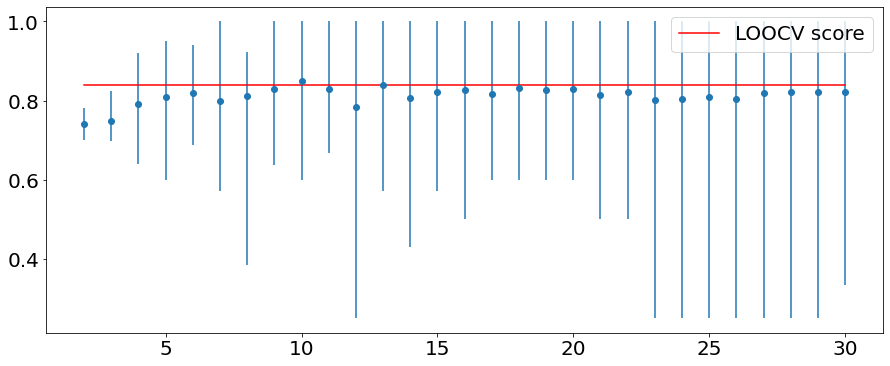

In [29]:
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 20

pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r', label = "LOOCV score")
pyplot.legend()
pyplot.show()

# Correlation of Test Harness With Target
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- **Question** when one algorithm looks better than another via k-Fold CV, does this hold on the ideal test condition?

- We can evaluate and report on this relationship explicitly. This can be achieved by calculating how well the k-fold cross-validation results across a range of algorithms match the evaluation of the same algorithms on the ideal test condition.

- The Pearson’s correlation coefficient can be calculated between the two groups of scores to measure how closely they match. That is, do they change together in the same ways: when one algorithm looks better than another via k-fold cross-validation, does this hold on the ideal test condition?

- We expect to see a strong positive correlation between the scores, such as 0.5 or higher. A low correlation suggests the need to change the k-fold cross-validation test harness to better match the ideal test condition.

</font>
</div>

In [31]:
# create the dataset
def get_dataset(n_samples=100):
    X, y = make_classification(
        n_samples=n_samples, n_features=20, n_informative=15, n_redundant=5, random_state=1)
    return X, y

In [32]:
# get a list of models to evaluate
def get_models():
    models = list()
    models.append(LogisticRegression())
    models.append(RidgeClassifier())
    models.append(SGDClassifier())
    models.append(PassiveAggressiveClassifier())
    models.append(KNeighborsClassifier())
    models.append(DecisionTreeClassifier())
    models.append(ExtraTreeClassifier())
    models.append(LinearSVC())
    models.append(SVC())
    models.append(GaussianNB())
    models.append(AdaBoostClassifier())
    models.append(BaggingClassifier())
    models.append(RandomForestClassifier())
    models.append(ExtraTreesClassifier())
    models.append(GaussianProcessClassifier())
    models.append(GradientBoostingClassifier())
    models.append(LinearDiscriminantAnalysis())
    models.append(QuadraticDiscriminantAnalysis())
    return models

In [33]:
# evaluate the model using a given test condition
def evaluate_model(cv, model):
    # get the dataset
    X, y = get_dataset()
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return mean(scores)

<div class="alert alert-info">
<font color=black>

- We can see that for some algorithms, the test harness over-estimates the accuracy compared to LOOCV, and in other cases, it under-estimates the accuracy. This is to be expected.

- At the end of the run, we can see that a strong positive correlation between the two sets of results is reported. The results suggest that 10-fold CV does provide a good approximation for the LOOCV test harness on this dataset as calculated with 18 popular machine learning algorithms.

</font>
</div>

In [36]:
# define test conditions
ideal_cv = LeaveOneOut()
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# get the list of models to consider
models = get_models()
# collect results
ideal_results, cv_results = list(), list()
# evaluate each model
for model in models:
    # evaluate model using each test condition
    cv_mean = evaluate_model(cv, model)
    ideal_mean = evaluate_model(ideal_cv, model)
    # check for invalid results
    if isnan(cv_mean) or isnan(ideal_mean):
        continue
    # store results
    cv_results.append(cv_mean)
    ideal_results.append(ideal_mean)
    # summarize progress
    print('>%s: ideal=%.3f, cv=%.3f' %
          (type(model).__name__, ideal_mean, cv_mean))

# calculate the correlation between each test condition
corr, _ = pearsonr(cv_results, ideal_results)
print('Correlation: %.3f' % corr)

>LogisticRegression: ideal=0.840, cv=0.850
>RidgeClassifier: ideal=0.830, cv=0.830
>SGDClassifier: ideal=0.740, cv=0.780
>PassiveAggressiveClassifier: ideal=0.790, cv=0.770
>KNeighborsClassifier: ideal=0.760, cv=0.770
>DecisionTreeClassifier: ideal=0.730, cv=0.690
>ExtraTreeClassifier: ideal=0.670, cv=0.700
>LinearSVC: ideal=0.840, cv=0.850
>SVC: ideal=0.900, cv=0.880
>GaussianNB: ideal=0.730, cv=0.720
>AdaBoostClassifier: ideal=0.740, cv=0.740
>BaggingClassifier: ideal=0.790, cv=0.680
>RandomForestClassifier: ideal=0.790, cv=0.810
>ExtraTreesClassifier: ideal=0.820, cv=0.790
>GaussianProcessClassifier: ideal=0.790, cv=0.760
>GradientBoostingClassifier: ideal=0.810, cv=0.810
>LinearDiscriminantAnalysis: ideal=0.830, cv=0.830
>QuadraticDiscriminantAnalysis: ideal=0.770, cv=0.770
Correlation: 0.828


<div class="alert alert-info">
<font color=black>

- A scatter plot is created comparing the distribution of mean accuracy scores for the test harness (x-axis) vs. the accuracy scores via LOOCV (y-axis).
- A red line of best fit is drawn through the results showing the strong linear correlation.

</font>
</div>

Correlation: 0.901


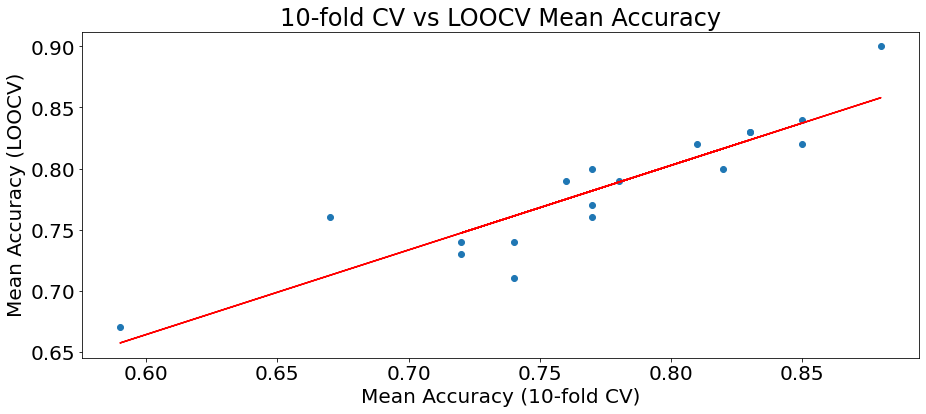

In [35]:

# scatter plot of results
pyplot.scatter(cv_results, ideal_results)
# plot the line of best fit
coeff, bias = polyfit(cv_results, ideal_results, 1)
line = coeff * asarray(cv_results) + bias
pyplot.plot(cv_results, line, color='r')
# label the plot
pyplot.title('10-fold CV vs LOOCV Mean Accuracy')
pyplot.xlabel('Mean Accuracy (10-fold CV)')
pyplot.ylabel('Mean Accuracy (LOOCV)')
# show the plot
pyplot.show()

# Conclusions
<hr style="border:2px solid black"> </hr>

<div class="alert alert-danger">
<font color=black>

- LOOCV can be used to tune the value of k in the k-Fold CV.

</font>
</div>

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

</font>
</div>